In [31]:
import pandas as pd
import numpy as np
import os
import json
import pprint
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from pylab import plot,show, legend
import numpy as np
import cPickle as pickle
import time
from sklearn import linear_model
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
import math
from sklearn import cross_validation
from sklearn.feature_selection import VarianceThreshold, RFE

%matplotlib inline

# Limit rows disp# Limit rows displayed in notebook
pd.set_option('display.max_rows', 20)
pd.set_option('display.precision', 2)
pylab.rcParams['figure.figsize'] = 12, 8

Loading business details

In [32]:
pd_lasvegas = pickle.load( open('pd_lasvegas_15.pkl', 'rb'))
pd_lasvegas = pd_lasvegas[np.isfinite(pd_lasvegas[u'attributes_Price Range'])]
pd_lasvegas.rename(columns={'date_x': 'review_date'}, inplace=True)
pd_lasvegas.rename(columns={'date_y': 'start_date'}, inplace=True)
pd_lasvegas.rename(columns={'stars_y': 'stars'}, inplace=True)
pd_lasvegas.reset_index(level=0, inplace=True)
pd_old_business_vegas = pd_lasvegas[pd_lasvegas['new'] == False]
pd_new_business_vegas = pd_lasvegas[pd_lasvegas['new'] == True]

Creating business vector

In [33]:
''' Business Attributes '''
   
attrs = [
         u'attributes_Accepts Credit Cards', 
         u'attributes_Accepts Insurance',
         u'attributes_Ages Allowed', 
         u'attributes_Alcohol',
         u'attributes_Ambience', 
         u'attributes_Attire', 
         u'attributes_BYOB',
         u'attributes_BYOB/Corkage', 
         u'attributes_By Appointment Only',
         u'attributes_Caters', 
         u'attributes_Coat Check',
         u'attributes_Corkage', 
         u'attributes_Delivery',
         u'attributes_Dietary Restrictions', 
         u'attributes_Dogs Allowed',
         u'attributes_Drive-Thru', 
         u'attributes_Good For Dancing', 
         u'attributes_Good For Groups',
         u'attributes_Good For Kids', 
         u'attributes_Hair Types Specialized In', 
         u'attributes_Happy Hour',
         u'attributes_Has TV', 
         u'attributes_Music',
         u'attributes_Noise Level', 
         u'attributes_Open 24 Hours',
         u'attributes_Order at Counter', 
         u'attributes_Outdoor Seating',
         u'attributes_Parking', 
         u'attributes_Payment Types',
         u'attributes_Price Range', 
         u'attributes_Smoking',
         u'attributes_Take-out', 
         u'attributes_Takes Reservations',
         u'attributes_Waiter Service', 
         u'attributes_Wheelchair Accessible',
         u'attributes_Wi-Fi', 
         u'categories',
         u'hours_Friday', 
         u'hours_Monday', 
         u'hours_Saturday',
         u'hours_Sunday', 
         u'hours_Thursday', 
         u'hours_Tuesday',
         u'hours_Wednesday',
        ]

def getHourAttr(old, new):
    if old[u'close'] == new[u'close'] and old[u'open'] == new[u'open']:
        return 1
    else:
        return -1

def getParkingAttr(old, new):
    parking_keys = [u'garage', u'street', u'validated', u'lot', u'valet']
    '''if np.isnan(old['attributes_Parking']) or math.isnan(new['attributes_Parking']):
        return -1
    '''
    for key in parking_keys:
        try:
            if old['attributes_Parking'][key]!= new['attributes_Parking'][key]:
                return -1
        except KeyError, e:
            '''print 'I got a KeyError - reason "%s"' % str(e)
            print "Old: ", old
            print "New: ", new
            break'''
            return -1
    return 1

def getCategoryAttr(old, new):
    #print old, new
    oldCategories = set(old.encode('utf8').split(','))
    newCategories = set(new.encode('utf8').split(','))
    L = len(oldCategories.intersection(newCategories))
    return L
    
def getVector(old, new):
    res = []
    old_count, new_count = 0, 0
    for attr in attrs:
            
        if pd.isnull(old[attr]) and pd.isnull(new[attr]):
            res.append(1)
            continue
            
        elif pd.isnull(old[attr]) or pd.isnull(new[attr]):
            res.append(-1)
            continue
            
        if 'hours_' in attr:
            res.append(getHourAttr(old[attr], new[attr]))
            continue
            
        if attr == u'categories':
            res.append(getCategoryAttr(old[attr], new[attr]))
            continue
            
        if attr == u'attributes_Parking':
            res.append(getParkingAttr(old, new))
            continue

        elif old[attr] == new[attr]:
            res.append(1)
        else:
            res.append(-1)
        
    return res

#Testing Out Vector Nonsense 

c = 14
pd_business =  pd_lasvegas[pd_lasvegas['cluster'] == c]
pd_old_business = pd_business[pd_business['new'] == False]
pd_new_business = pd_business[pd_business['new'] == True]
print getVector(pd_old_business.iloc[0], pd_new_business.iloc[0])

#gb_neighbourhood = pd_lasvegas.groupby([u'neighborhoods'])
#groups = dict(list(gb_neighbourhood))

[1, 1, 1, -1, -1, -1, 1, 1, 1, -1, 1, 1, -1, 1, 1, 1, 1, -1, 1, 1, 1, -1, 1, -1, 1, 1, -1, 1, 1, 1, 1, -1, -1, -1, -1, -1, 0, -1, -1, -1, -1, -1, -1, -1]


Calculating Conditional Mean For Each Business

In [59]:
import datetime
''' Helper for Date in Pandas'''
def todate(d):
    return datetime.datetime.strptime(d, '%Y-%m-%d')


''' Calculate mean_after - mean_before : returns +1 if mean improves -1 if mean reduces'''
def calcAverage(df):
    #print "Printing DF", df
    df_before = df[df['before'] == True]
    df_after = df[df['before'] == False]
    
    #print "before", df_before
    #print "after", df_after
    
    l1 = len(df_before['stars'])
    l2 = len(df_after['stars'])

    if l1 == 0 or l2 == 0:
        return -1
    else:
        a = sum(df_before['stars']) / (len(df_before['stars'])*1.0)
        b = sum(df_after['stars']) / (len(df_after['stars'])*1.0)
        if a - b > 0:
            return -1
        else:
            return 1
        
def createTrainingData(clusterFlag=True, cluster=0, neighbour=u'Anthem', category="Hotels", date_range=60, sampleAll=False, maxsamples=10000):
    # Use cluster 0,1 for training
    X, Y = [], []

    diff = datetime.timedelta(days=date_range)
    if clusterFlag:
        pd_business =  pd_lasvegas[pd_lasvegas['cluster'] == cluster]
    else:
        #pd_business =  pd_lasvegas[pd_lasvegas[u'neighborhoods'] == neighbour]
        pd_business = pd_lasvegas[pd_lasvegas[u'categories'] == category]
        
    pd_old_business = pd_business[pd_business['new'] == False]
    #pd_old_business_Y = pd_business_cluster[["business_id", "review_date", "stars"]] # This is to simplify Y calculation
    pd_new_business = pd_business[pd_business['new'] == True]
    gb_new_business = pd_new_business.groupby('business_id')
    gb_old_business = pd_old_business.groupby('business_id')

    
    #print "Calculating vector for neighbour ", neighbour
    start_time = time.time()
    for new_business_id, new_business_details in gb_new_business:
        start_date = todate(pd_new_business.iloc[0]['start_date'])
        new_business = new_business_details.iloc[0]
        
        ''' Calculating Y for Current New Business '''
        # Getting all old business reviews between start_date -diff to start_date + diff
        pd_old_business_tempY = pd_old_business[pd_old_business.review_date.apply(todate) <= start_date + diff]
        pd_old_business_tempY = pd_old_business_tempY[pd_old_business_tempY.review_date.apply(todate) >= start_date - diff]
        
        # Labelling All Reviews Before Start Date as True
        pd_old_business_tempY['before'] = (pd_old_business_tempY['review_date'].apply(todate) < start_date)
        
        #print pd_old_business_tempY.groupby('business_id')
        gb_old_business_tempY = pd_old_business_tempY.groupby(['business_id'])
        temp_y = gb_old_business_tempY.apply(calcAverage).values.tolist()
        
        ''' Calculating X for Current New Business '''
        temp_x = []
        for old_business_id, old_business_details in gb_old_business_tempY:
            old_business = old_business_details.iloc[0]
            #print old_business
            temp_x.append(getVector(old_business, new_business))
            
            
        X.extend(temp_x)
        Y.extend(temp_y)
        
        if sampleAll == False and len(X) > maxsamples:
            break

    end_time = time.time()
    #print "Time taken for neighbour ", neighbour, " is ", end_time - start_time
    #print "Completed calculating vector for neighbour ", neighbour
    return X, Y

def getFeatures(flags):
    new_attrs = []
    for idx, flag in enumerate(flags):
        if flag:
            new_attrs.append( attrs[idx] )
    print new_attrs

Calculating Accuracy/Time

In [ ]:
logistic = linear_model.LogisticRegression()
clf = SVC(kernel='rbf')
results = {}
c = 0
print "Starting with cluster ",c
stime = time.time()
results[c] = []
for d in range(7, 120, 7):
    print "At time point ", d
    X, Y = createTrainingData(cluster=c, date_range=d, sampleAll=False, maxsamples=20000)
    print len(X)
    X_np, Y_np = np.array(X), np.array(Y)
    scores = cross_validation.cross_val_score(logistic, X_np, Y_np, cv=5)
    results[c].append(scores.mean())
    print("Logistic Regression Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Completed cluster ", c, " time taken ", time.time() - stime

Calculating Accuracy For Neighbourhood

In [39]:
logistic = linear_model.LogisticRegression()
clf = SVC(kernel='rbf')

X, Y = createTrainingData(clusterFlag=False, neighbour= u'The Strip', sampleAll=False, maxsamples=20000)
X_np, Y_np = np.array(X), np.array(Y)
scores = cross_validation.cross_val_score(logistic, X_np, Y_np, cv=5)
print("Logistic Regression Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Logistic Regression Accuracy: 0.65 (+/- 0.01)


NameError: name 'X_train' is not defined

Calculating Accuracy of Neighbourhood with Category

In [ ]:
categories = ["Hotels & Travel,Arts & Entertainment,Casinos,Event Planning & Services,Hotels",
"Buffets,Restaurants",
"Mexican,Restaurants",
"Arts & Entertainment,Resorts,Casinos,Event Planning & Services,Hotels & Travel,Hotels",
"Restaurants,Italian",
"Sushi Bars,Japanese,Restaurants",
"Steakhouses,Restaurants",
"American (Traditional),Restaurants",
"Hotels & Travel,Event Planning & Services,Hotels",
"Pizza,Restaurants"]


for c in categories:
    X, Y = createTrainingData(clusterFlag=False, category=c, sampleAll=False, maxsamples=20000)
    X_np, Y_np = np.array(X), np.array(Y)
    if len(X_np)> 50:
        scores = cross_validation.cross_val_score(logistic, X_np, Y_np, cv=5)
        print "For category ", c
        print("Logistic Regression Accuracy: %0.2f (+/- %0.2f), Samples: %f" % (scores.mean(), scores.std() * 2, len(X_np)))
    else:
        continue

For category  Hotels & Travel,Arts & Entertainment,Casinos,Event Planning & Services,Hotels
Logistic Regression Accuracy: 0.71 (+/- 0.11), Samples: 176.000000
For category 

Learning Algorithm: Logistic Regression/SVM

In [13]:
from sklearn import neighbors, linear_model

print "At cluster ", i
X_np, Y_np = np.array(X), np.array(Y)
logistic = linear_model.LogisticRegression()
scores = cross_validation.cross_val_score(logistic, X_np, Y_np, cv=5)
print "Regression Scores: ", scores

#sampling_mask_train =np.random.randint(len(X),size=10000)
#sampling_mask_test =np.random.randint(len(X),size=2500)
#X_train, Y_train = X_np[sampling_mask_train,:], Y_np[sampling_mask_train]
#X_test, Y_test = X_np[sampling_mask_test,:], Y_np[sampling_mask_test]

clf = SVC(kernel='rbf')
print('SVM score: %f' % clf.fit(X_train, Y_train).score(X_test, Y_test))
scores = cross_validation.cross_val_score(clf, X_np, Y_np, cv=5)
print  "SVM Scores: " , scores

clf2 = SVC(kernel='linear')
print('Linear SVM score: %f' % clf2.fit(X_train, Y_train).score(X_test, Y_test))
clf3 = SVC(kernel='poly')
print('Poly Linear SVM score: %f' % clf3.fit(X_train, Y_train).score(X_test, Y_test))
clf4 = SVC(kernel='sigmoid')
print('Sigmoid Linear SVM score: %f' % clf4.fit(X_train, Y_train).score(X_test, Y_test))

clf = SVC(kernel='rbf')
print('SVM score: %f' % clf.fit(X_train, Y_train).score(X_test, Y_test))

At cluster  60
Regression Scores:  [ 1.          0.66666667  1.          1.          1.        ]


/Library/Python/2.7/site-packages/sklearn/cross_validation.py:417: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)


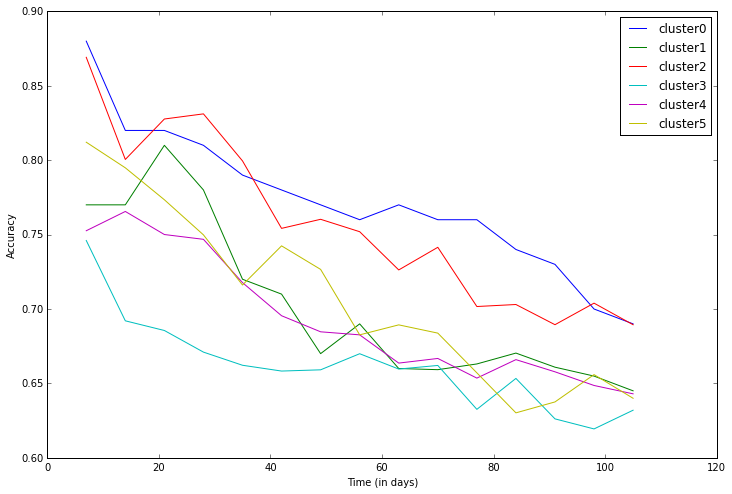

In [9]:
time = [7, 14, 21, 28, 35, 42, 49, 56, 63, 70, 77, 84, 91, 98, 105] 
C = [
[0.88, 0.82, 0.82, 0.81, 0.79, 0.78, 0.77, 0.76, 0.77,  0.76, 0.76, 0.74, .73, .70, .69],
[0.77, 0.77, 0.81, 0.78, 0.72, 0.71 , 0.67, 0.69, 0.66, 0.65922850600988103, 0.66307385229540916, 0.6703791216418078, 0.66090131664524376, 0.6549169707573107, 0.64501339573049921],
[0.86914689816544333, 0.80050578806541528, 0.82768965827494512, 0.83113273515625252, 0.79952520905234825, 0.75419092891756923, 0.7602870813397129, 0.75194682149178327, 0.72625266097257579, 0.74146502859237062, 0.7016679113766493, 0.70301923844234415, 0.68945409324314377, 0.70393347440251375, 0.68941968658969488],
[0.74603725473247473, 0.69205801113897381, 0.68555649227538151, 0.6710266862169032, 0.66218921726228186, 0.65829576382679866, 0.65912616055631357, 0.66994144863451166, 0.65963348192174343, 0.66206558981889374, 0.63256427326694675, 0.65334609968115187, 0.62616073163041275, 0.61940574409490368, 0.63198323301191839],
[0.75258850730587146, 0.76555147710828653,0.75005007404897195, 0.74683111326768414, 0.71772044794018741, 0.69547525242501984, 0.68467261904761911, 0.68262931234252222, 0.66364958656032036, 0.66676619147798877, 0.65355867359297637, 0.66597222222222219, 0.65778769841269846, 0.64860634142419327, 0.64299092429713656],   
[0.81208932963338309, 0.79488128683096593, 0.77341276656395275, 0.74982523717544791, 0.71611920334139112, 0.7424333495846267, 0.72661764705882348, 0.68262469022286976, 0.68933832709113607, 0.68379048995599689, 0.65710044532409706, 0.63021130967779082, 0.63754709866549919, 0.65590277777777772, 0.64]
]

for idx, c in enumerate(C):
    plt.plot(time,c, label="cluster"+str(idx)) 
plt.legend()
plt.ylabel("Accuracy")
plt.xlabel("Time (in days)")
plt.show()

In [28]:
df = pd_lasvegas['categories']
print len(pd.Series(df.values.ravel()).unique())
print pd.value_counts(df)

2009
Hotels & Travel,Arts & Entertainment,Casinos,Event Planning & Services,Hotels                                       25977
Buffets,Restaurants                                                                                                 17394
Mexican,Restaurants                                                                                                 16095
Arts & Entertainment,Resorts,Casinos,Event Planning & Services,Hotels & Travel,Hotels                               15317
Restaurants,Italian                                                                                                 11277
Sushi Bars,Japanese,Restaurants                                                                                     11258
Steakhouses,Restaurants                                                                                             10382
American (Traditional),Restaurants                                                                                   9679
Hotels & Travel,Eve